In [6]:
pip install annoy

In [10]:
pip install torch==3.7

ERROR: Could not find a version that satisfies the requirement torch==3.7 (from versions: 0.1.2, 0.1.2.post1, 0.1.2.post2, 0.4.1, 0.4.1.post2, 1.0.0, 1.0.1, 1.0.1.post2, 1.1.0, 1.2.0, 1.3.0, 1.3.1, 1.4.0, 1.5.0, 1.5.1, 1.6.0, 1.7.0, 1.7.1, 1.8.0, 1.8.1, 1.9.0)
ERROR: No matching distribution found for torch==3.7


In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from fastai import *
from fastai.vision import *
from fastai.callbacks import *

np.random.seed(42)
torch.cuda.set_device(0)

from annoy import AnnoyIndex

import glob

In [12]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [13]:
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 1000)


In [14]:
class SaveFeatures():
    features=None
    def __init__(self, m): 
        self.hook = m.register_forward_hook(self.hook_fn)
        self.features = None
    def hook_fn(self, module, input, output): 
        out = output.detach().cpu().numpy()
        if isinstance(self.features, type(None)):
            self.features = out
        else:
            self.features = np.row_stack((self.features, out))
    def remove(self): 
        self.hook.remove()

In [24]:
#loads cnn pkl file
def load_cnn(pkl_filename):
    learn = load_learner(path='/content/drive/MyDrive/Colab Notebooks/FashionRecommendations/CNN/K-Fashion 이미지/원천데이터/레트로/', file=pkl_filename)
    return learn

# returns the embeddings for a single image,
# from a single given CNN's last FC layer
def get_embeddings_for_image(cnn, img_path):
    hook = hook_output(cnn.model[-1][-3])
    cnn.predict(open_image(img_path))
    hook.remove()
    return hook.stored.cpu()[0]

# returns the concatenated embeddings for a single image,
# from the given list of CNNs' last FC layer
def get_combined_embeddings_for_image(cnns, img_path):
    embeddings = []
    for cnn in cnns:
        embeddings.append(get_embeddings_for_image(cnn, img_path))

    return np.concatenate(embeddings)

# returns the embeddings for multiple image, from
# a single given CNN's last FC layer
def get_embeddings_for_images(cnn, img_paths):
    sf = SaveFeatures(cnn.model[-1][-3])
    cnn.data.add_test(img_paths)
    cnn.get_preds(DatasetType.Test)
    sf.remove()
    return sf.features

# returns the embeddings for multiple image, from
# a list of given CNNs' last FC layer
def get_combined_embeddings_for_images(cnns, img_paths):
    embeddings = []
    for cnn in cnns:
        embeddings.append(get_embeddings_for_images(cnn, img_paths))

    return np.concatenate(embeddings, axis=1)

# creates an ANN index from the given list of embeddings
def create_ann_index(embeddings, dim = 512, trees = 10):
    ann_index = AnnoyIndex(dim)
    for i in range(len(embeddings)):
        ann_index.add_item(i, embeddings[i])
    ann_index.build(trees)
    return ann_index

# queries the given vector against the given ANN index
def query_ann_index(ann_index, dataset, embeddings, n = 5):
    nns = ann_index.get_nns_by_vector(embeddings, n=n, include_distances=True)
    img_paths = [dataset[i] for i in nns[0]]
    return img_paths, nns[1]

# displays the list of given image paths
def display_images(img_paths, sim_scores):
    for i, img_path in enumerate(img_paths):
        print(sim_scores[i])
        show_image(open_image(img_path))
        
        
# Get and display recs 
def get_recs(img_path, cnns, ann_index, dataset, n=5):
    embedding = get_combined_embeddings_for_image(cnns, img_path)
    img_paths, sim_scores = query_ann_index(ann_index, dataset, embedding, n)
#     return display_images(img_paths, sim_scores)
    return img_paths, sim_scores
    

In [25]:
cat_learner = load_cnn('cat-rn50-size150-fr4-unfr2.pkl')

In [ ]:
texture_learner = load_cnn('texture-resnet50-size150-fr12-unfr4.pkl')

In [26]:
fabric_learner = load_cnn('fabric-resnet50-size150-fr5-unfr4.pkl')

In [ ]:
parts_learner = load_cnn('parts-resnet50-size150-fr5-unfr4.pkl')

In [ ]:
shape_learner = load_cnn('shape-resnet50-size150-fr5-unfr4.pkl')

In [28]:
all_cnns = [cat_learner, fabric_learner]#,texture_learner, parts_learner, shape_learner]

def build_inventory_ann_index(img_paths):
    print("Inventory size: {} images".format(len(img_paths)))
    
    combined_embeddings = get_combined_embeddings_for_images(all_cnns, img_paths)
    print("Got {} embeddings".format(len(combined_embeddings)))
    
    ann_index = create_ann_index(combined_embeddings, 512 * len(all_cnns), 10)
    print("ANN index has {} items".format(ann_index.get_n_items()))
    
    return ann_index


In [30]:
# build a RTR inventory index
rtr_images = glob.glob("/content/drive/MyDrive/Colab Notebooks/FashionRecommendations/CNN/K-Fashion 이미지/원천데이터/레트로/**/*.jpg", recursive=True)
rtr_inventory = build_inventory_ann_index(rtr_images)
rtr_inventory.save('rtr_inventory_5cnn.ann')

Inventory size: 687 images


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3658: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  "The default behavior for interpolate/upsample with float scale_factor changed "


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3658: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  "The default behavior for interpolate/upsample with float scale_factor changed "
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3658: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  "The default behavior for interpolate/upsample with float scale

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3658: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  "The default behavior for interpolate/upsample with float scale_factor changed "
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3658: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  "The default behavior for interpolate/upsample with float scale

Got 687 embeddings
ANN index has 687 items


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:43: FutureWarning: The default argument for metric will be removed in future version of Annoy. Please pass metric='angular' explicitly.


True

In [31]:
with open('rtr_images.pkl', 'wb') as f:
    pickle.dump(rtr_images, f)

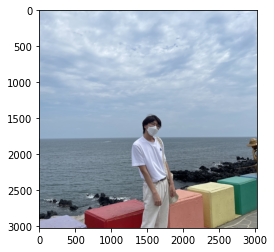

In [40]:
from matplotlib import image

# load the image
data = image.imread('/content/drive/MyDrive/Colab Notebooks/FashionRecommendations/Recommendation/whitejeju.jpg')

plt.imshow(data)
plt.show()

In [44]:
get_recs('/content/drive/MyDrive/Colab Notebooks/FashionRecommendations/Recommendation/whitejeju.jpg',all_cnns, rtr_inventory, rtr_images, 3)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3658: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  "The default behavior for interpolate/upsample with float scale_factor changed "
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3658: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  "The default behavior for interpolate/upsample with float scale

(['/content/drive/MyDrive/Colab Notebooks/FashionRecommendations/CNN/K-Fashion 이미지/원천데이터/레트로/nt1643c9al-600_4.jpg',
  '/content/drive/MyDrive/Colab Notebooks/FashionRecommendations/CNN/K-Fashion 이미지/원천데이터/레트로/1103 신규작업-4-output-2-(1733)-1.jpg',
  '/content/drive/MyDrive/Colab Notebooks/FashionRecommendations/CNN/K-Fashion 이미지/원천데이터/레트로/80426(대행)24-bl13-2080 (4379).jpg'],
 [0.9962987899780273, 1.0022441148757935, 1.0245885848999023])

# Favorite recs:

### 1: 
cat_learner = load_cnn('cat-rn50-size150-fr4-unfr2-fr4-unfr4.pkl') <br/>
texture_learner = load_cnn('texture-resnet50-size150-fr12-unfr4.pkl') <br/>
fabric_learner = load_cnn('fabric-resnet50-size150-fr5-unfr4.pkl') <br/>
parts_learner = load_cnn('parts-resnet50-size150-fr5-unfr4.pkl') <br/>
shape_learner = load_cnn('shape-resnet50-size150-fr5-unfr4.pkl')

### 2:
cat_learner = load_cnn('cat-rn50-size150-fr4-unfr2-fr4-unfr4.pkl') <br/>
texture_learner = load_cnn('texture-resnet50-size150-fr12-unfr4.pkl') <br/>
fabric_learner = load_cnn('fabric-resnet50-size150-fr5-unfr4.pkl') <br/>
parts_learner = load_cnn('parts-resnet50-size150-fr5-unfr4.pkl')

### 3:
cat_learner = load_cnn('cat-rn50-size150-fr4-unfr2.pkl') <br/> 
texture_learner = load_cnn('texture-resnet50-size150-fr12-unfr4.pkl')